# Example
Comparison between swept wing by Bertin and pySailingVLM results. More information can be found at Aerodynamics for engineers John J.Bertin p 368 (Example 7.2).

In [14]:
# varaibles.py for jupyter
import os
import numpy as np
import time

half_wing_span = 0.5
sweep_angle_deg = 45.
chord_length = 0.2
AoA_deg = 4.
mgirths =  np.array([0.00, 1./8, 1./4, 1./2, 3./4, 7./8, 1.00])
mchords = np.array([chord_length]* len(mgirths))

   
output_args = {
    'case_name': 'my_case_name',  # get name of the current file
    'case_dir': os.path.abspath(''), # get dir of the current file
    'name': os.path.join("results_example_jib_and_mainsail_vlm", time.strftime("%Y-%m-%d_%Hh%Mm%Ss")),
    'file_name': 'my_fancy_results', # name of xlsx excel file
}

solver_args = {
    'n_spanwise':  4,  # No of control points (above the water) per sail, recommended: 50
    'n_chordwise': 1, # No of control points (above the water) per sail, recommended: 50
    'interpolation_type': "linear",  # either "spline" or "linear"
    'LLT_twist': "real_twist",  # defines how the Lifting Line discretize the sail twist.
}

conditions_args = {
    'leeway_deg': 0.,    # [deg]
    'heel_deg': 0.,     # [deg]
    'SOG_yacht': 0.,   # [m/s] yacht speed - speed over ground (leeway is a separate variable)
    'tws_ref': 1.0,     # [m/s] true wind speed
    'alpha_true_wind_deg': AoA_deg,   # [deg] true wind angle (with reference to course over ground) => Course Wind Angle to the boat track = true wind angle to centerline + Leeway
    'reference_water_level_for_wind_profile': -0.,  # [m] this is an attempt to mimick the deck effect
    # by lowering the sheer_above_waterline
    # while keeping the wind profile as in original geometry
    # this shall be negative (H = sail_ctrl_point - water_level)
    'wind_exp_coeff': 0.,  # [-] coefficient to determine the exponential wind profile
    'wind_reference_measurment_height': 10.,  # [m] reference height for exponential wind profile
    'rho': 1.,  # air density [kg/m3]
    'wind_profile': 'flat', # allowed: 'exponential' or 'flat' or 'logarithmic'
    'roughness': 0.05, # for logarithmic profile only 
}


rig_args = {
    'main_sail_luff': half_wing_span / np.cos(np.deg2rad(sweep_angle_deg)),  # [m]
    'jib_luff': 10.0,  # [m]
    'foretriangle_height': 11.50,  # [m]
    'foretriangle_base': 3.90,  # [m]
    'sheer_above_waterline': 0.,#[m]
    'boom_above_sheer': 0., # [m],
    'rake_deg': 90. + sweep_angle_deg,  # rake angle [deg]
    'mast_LOA': 0.,  # [m]
    'sails_def': 'main', # definition of sail set, possible: 'jib' or 'main' or 'jib_and_main'
}


# INFO for camber:
# First digit describing maximum camber as percentage of the chord.
# Second digit describing the distance of maximum camber from the airfoil leading edge in tenths of the chord.
main_sail_args = {
    'girths' : mgirths,
    'chords': mchords,
    'centerline_twist_deg': 0*mgirths,
    'camber': 0*np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
    'camber_distance_from_luff': np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
}
 

jgirths = np.array([0.00, 1./4, 1./2, 3./4, 1.00])
jib_sail_args = {
    'centerline_twist_deg': 0*(10+5)  + 0*15. * jgirths,
    'girths': jgirths,
    'chords': 0* np.array([3.80, 2.98, 2.15, 1.33, 0.5]),
    'camber': 0*np.array([0.01, 0.01, 0.01, 0.01, 0.01]),
    'camber_distance_from_luff': np.array([0.5, 0.5, 0.5, 0.5, 0.5]), # starting from leading edge   
}        

# REFERENCE CSYS
# The origin of the default CSYS is located @ waterline level and aft face of the mast
# The positive x-coord: towards stern
# The positive y-coord: towards leeward side
# The positive z-coord: above the water
# To shift the default CSYS, adjust the 'reference_level_for_moments' variable.
# Shifted CSYS = original + reference_level_for_moments
# As a results the moments will be calculated around the new origin.

# yaw_reference [m] - distance from the aft of the mast towards stern, at which the yawing moment is calculated.
# sway_reference [m] - distance from the aft of the mast towards leeward side. 0 for symmetric yachts ;)
# heeling_reference [m] - distance from the water level,  at which the heeling moment is calculated.
csys_args = {
    'reference_level_for_moments': np.array([0, 0, 0]),  # [yaw_reference, sway_reference, heeling_reference]
}

# GEOMETRY OF THE KEEL
# to estimate heeling moment from keel, does not influence the optimizer.
# reminder: the z coord shall be negative (under the water)
keel_args={
    'center_of_lateral_resistance_upright': np.array([0, 0, -1.0]),  # [m] the coordinates for a yacht standing in upright position
}  


<div class="alert alert-block alert-warning">
<b>Run cell below twice:</b> Run cell below twice before running other cells. Output below is expected to always appear at first time importing pySailingVLM:
<br><br>
    
<em>   
/home/user/miniconda3/envs/mgr_test/lib/python3.10/site-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7f01d6a1e9e0 at 0x7f01d6cfa680>. Debug line information may be inaccurate.warnings.warn(NumbaDebugInfoWarning(msg))
</em> 
<br>
</div>

In [15]:
import shutil
from pySailingVLM.rotations.csys_transformations import CSYS_transformations
from pySailingVLM.yacht_geometry.hull_geometry import HullGeometry
from pySailingVLM.results.save_utils import save_results_to_file
from pySailingVLM.solver.panels_plotter import display_panels_xyz_and_winds
from pySailingVLM.results.inviscid_flow import InviscidFlowResults
from pySailingVLM.solver.vlm import Vlm
from pySailingVLM.runner.sail import Wind, Sail
from pySailingVLM.runner.container import Output, Rig, Conditions, Solver, MainSail, JibSail, Csys, Keel

from pySailingVLM.solver.panels_plotter import plot_cp

In [16]:
import numpy as np

AoA_degs = np.linspace(0.001, 10., 20)
C_results = []
a_vlm_results = []
for AoA_deg in AoA_degs:
    conditions_args['alpha_true_wind_deg'] = AoA_deg
    
    out = Output(**output_args)
    conditions = Conditions(**conditions_args)
    solver = Solver(**solver_args)
    main = MainSail(**main_sail_args)
    jib = JibSail(**jib_sail_args)
    csys = Csys(**csys_args)
    keel = Keel(**keel_args)
    rig = Rig(**rig_args)
    csys_transformations = CSYS_transformations(conditions.heel_deg, conditions.leeway_deg, v_from_original_xyz_2_reference_csys_xyz=csys.reference_level_for_moments)


    w = Wind(conditions)
    s = Sail(solver, rig, main, jib, csys_transformations)
    sail_set = s.sail_set
    myvlm = Vlm(sail_set.panels, solver.n_chordwise, solver.n_spanwise, conditions.rho, w.profile, sail_set.trailing_edge_info, sail_set.leading_edge_info)
    sails_Cxyz = myvlm.get_Cxyz(w, 1.0)

        # enumerate through sails
        # in this example we have only main
    for idx, Cxyz in enumerate(sails_Cxyz):
        a_vlm = Cxyz[1] / np.deg2rad(AoA_deg)
        C_results.append(Cxyz[1])
        a_vlm_results.append(Cxyz[1])


In [17]:
# results from Aerodynamics for engineers John J.Bertin p 368
C_bertin = 0.0601 * AoA_degs

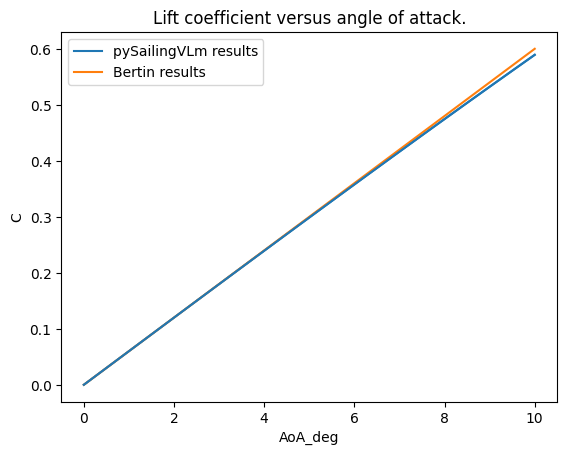

In [21]:
# importing matplotlib module
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(AoA_degs, C_results, color='tab:blue', label='pySailingVLm results')
ax.plot(AoA_degs, C_bertin, color='tab:orange', label='Bertin results')

ax.set_xlabel("AoA_deg")
ax.set_ylabel("C")
ax.set_title("Lift coefficient versus angle of attack.")
ax.legend()
plt.plot(AoA_degs, C_results)

    